# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

In [0]:
%tensorflow_version 2.x

In [2]:
import tensorflow
tensorflow.__version__

'2.2.0-rc1'

In [0]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Change current working directory to project folder (1 mark)

In [0]:
import os
#### Add your code here ####
os.chdir('/content/drive/My Drive')

### Extract the zip file (5 Marks)
- Extract Aligned Face Dataset from Pinterest.zip

In [0]:
from zipfile import ZipFile

with ZipFile('Aligned Face Dataset from Pinterest.zip', 'r') as z:
  z.extractall()

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [0]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

In [7]:
metadata.shape

(10770,)

### Define function to load image
- Define a function to load image from the metadata

In [0]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image (5 Marks)
- Load one image using the function "load_image"

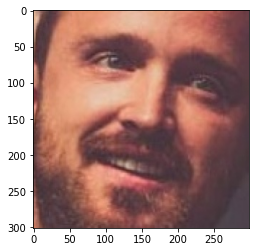

In [0]:
sample_image=load_image(metadata[0].image_path())
plt.imshow(sample_image)

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model (5 Marks)
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [0]:
WEIGHTS_FILE2 ="/content/drive/My Drive/vgg_face_weights.h5"

model =vgg_face()
model.load_weights(WEIGHTS_FILE2)

### Get vgg_face_descriptor

In [0]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [0]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images (5 marks)
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [0]:
def gen_embeddings():
  embeddings=[]
  for i in range(metadata.shape[0]):
    try:
      img_path = metadata[i].image_path()
      img = load_image(img_path)
      # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
      img = (img / 255.).astype(np.float32)
      img = cv2.resize(img, dsize = (224,224))
      embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    except:
      embedding_vector=np.zeros(2622,)
    embeddings.append(embedding_vector)
  return embeddings

embeddings=gen_embeddings()



In [0]:
np.array(embeddings).shape

(10770, 2622)

In [0]:
dir_list = next(os.walk('PINS'))[1]
dir_list

['pins_Aaron Paul',
 'pins_Alvaro Morte',
 'pins_Amanda Crew',
 'pins_Amaury Nolasco',
 'pins_Anna Gunn',
 'pins_Benedict Cumberbatch',
 'pins_Betsy Brandt',
 'pins_Brenton Thwaites',
 'pins_Brit Marling',
 'pins_Bryan Cranston',
 'pins_Caity Lotz',
 'pins_Cameron Monaghan',
 'pins_Chance Perdomo',
 'pins_Chris Evans',
 'pins_Chris Pratt',
 'pins_Cobie Smulders',
 'pins_Danielle Panabaker',
 'pins_Dave Franco',
 'pins_Dominic Purcell',
 'pins_Dwayne Johnson',
 'pins_Emilia Clarke',
 'pins_Emily Bett Rickards',
 'pins_Emma Stone',
 'pins_Gwyneth Paltrow',
 'pins_Henry Cavil',
 'pins_Jason Momoa',
 'pins_Jeremy Renner',
 'pins_Jesse Eisenberg',
 'pins_Jim Parsons',
 'pins_Jon Bernthal',
 'pins_Josh Radnor',
 'pins_Kit Harington',
 'pins_Krysten Ritter',
 'pins_Kumail Nanjiani',
 'pins_Maisie Williams',
 'pins_Mark Ruffalo',
 'pins_Martin Starr',
 'pins_Melissa benoit',
 'pins_Mike Colter',
 'pins_Morena Baccarin',
 'pins_Morgan Freeman',
 'pins_Natalie Portman ',
 'pins_Neil Patrick Harr

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [0]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

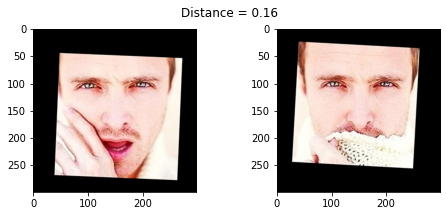

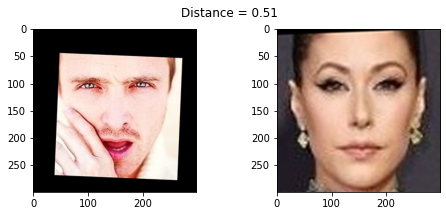

In [0]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

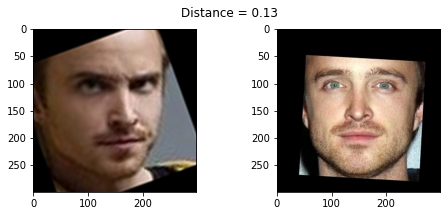

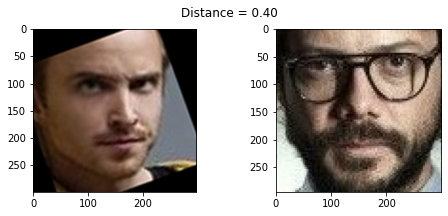

In [0]:
show_pair(30, 31)
show_pair(30, 100)

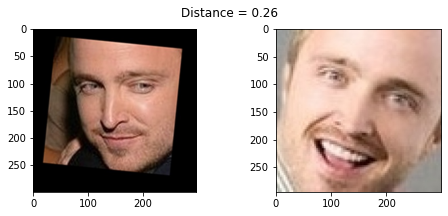

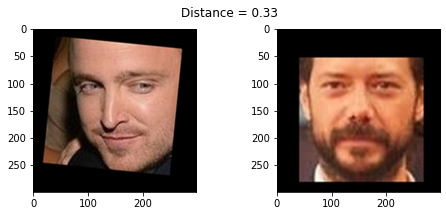

In [0]:
show_pair(70, 72)
show_pair(70, 115)

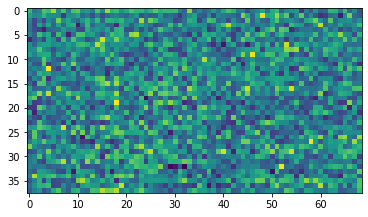

In [0]:
plt.imshow(np.reshape(np.array(embeddings[3]),(38,69)))

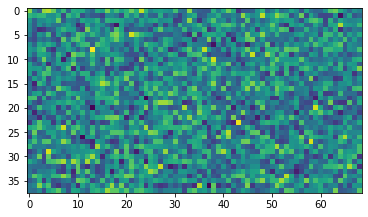

In [0]:
plt.imshow(np.reshape(np.array(embeddings[2]),(38,69)))

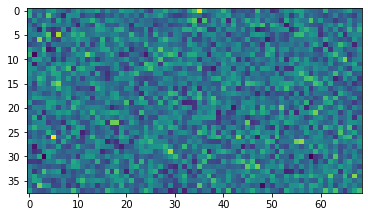

In [0]:
plt.imshow(np.reshape(np.array(embeddings[180]),(38,69)))

We can evidently see the difference in the embeddings between similar and dissimilar images

### Create train and test sets (5 marks)
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [0]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

In [0]:
metadata.shape

(10770,)

In [0]:
embeddings[1].size

2622

In [0]:
train_idx[0]

False

In [0]:
X_train=[]
y_train=[]
X_test=[]
y_test=[]
for i in range(0,metadata.shape[0]):
  if train_idx[i]== True:
    X_train.append(embeddings[i])
    y_train.append(metadata[i].name)
  if test_idx[i]== True:
    X_test.append(embeddings[i])
    y_test.append(metadata[i].name)

In [0]:
np.array(X_train).shape

(9573, 2622)

In [0]:
np.array(y_test).shape

(1197,)

In [0]:
test_idx.sum()

1197

### Encode the Labels (5 marks)
- Encode the targets
- Use LabelEncoder

In [0]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(y_train)
Y=le.transform(y_train)
Yt=le.transform(y_test)

In [0]:
le.classes_.size

100

In [0]:
Yt[5]

0

In [0]:
Y[50]

0

### Standardize the feature values (5 marks)
- Scale the features using StandardScaler

In [0]:
# Standarize features
from sklearn.preprocessing import StandardScaler

ss=StandardScaler()
ss.fit(X_train)
X=ss.transform(X_train)
Xt=ss.transform(X_test)

In [0]:
xx=np.array(X_train)
tt=(xx[:,10]-xx[:,10].mean())/xx[:,10].std()

In [0]:
np.array(X)[:,10]

array([-0.27371149, -0.91897248, -0.04927329, ..., -0.39097955,
       -0.54617927,  1.10920305])

In [0]:
tt

array([-0.27371149, -0.91897248, -0.04927329, ..., -0.39097955,
       -0.54617927,  1.10920305])

Thus the standard scaler results are verified

In [0]:
for i in range(10):
  print(np.array(X)[:,i].mean(),  np.array(X)[:,i].std())

7.125467735607397e-17 1.0000000000000007
-2.3751559118691327e-17 0.9999999999999992
-2.5236031563609534e-17 0.999999999999999
5.937889779672831e-17 1.0000000000000007
1.1875779559345663e-17 1.0000000000000002
8.313045691541964e-17 1.0000000000000002
1.4844724449182077e-17 1.0000000000000022
6.680126002131935e-17 1.0000000000000002
1.1875779559345663e-17 0.9999999999999994
-2.968944889836416e-18 0.9999999999999998


### Reduce dimensions using PCA (5 Marks)
- Reduce feature dimensions using Principal Component Analysis

In [0]:
from sklearn.decomposition import PCA

In [0]:
pc5=PCA(n_components=500)
pc5.fit(X)
XP5=pc5.transform(X)
XtP5=pc5.transform(Xt)

pc7=PCA(n_components=700)
pc7.fit(X)
XP7=pc7.transform(X)
XtP7=pc7.transform(Xt)

pc9=PCA(n_components=900)
pc9.fit(X)
XP9=pc9.transform(X)
XtP9=pc9.transform(Xt)

pc11=PCA(n_components=1100)
pc11.fit(X)
XP11=pc11.transform(X)
XtP11=pc11.transform(Xt)

pc15=PCA(n_components=1500)
pc15.fit(X)
XP15=pc15.transform(X)
XtP15=pc15.transform(Xt)

### Build a Classifier (3 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [0]:
from sklearn.svm import SVC

clf = SVC(gamma=0.025, C=3)  
clf.fit(XP5, Y)

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.025, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
clf.score(XtP5, Yt)

0.03508771929824561

Lets try linear kernel

In [0]:
clf1 = SVC(gamma=0.025, C=3,kernel='linear')  
clf1.fit(XP5, Y)
clf1.score(XtP5, Yt)

0.9590643274853801

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
trial=[500,700,900,1100,1500,2622]
XX=[XP5,XP7,XP9,XP11,XP15,X]

In [0]:
score=[]
count=[]
for i in XX:
  clf1 = SVC(gamma=0.025, C=3,kernel='linear')  
  x,xv,y,yv=train_test_split(i,Y,test_size=0.1)
  clf1.fit(x, y)
  score.append(clf1.score(xv, yv))
  j= clf1.predict(xv)==yv
  count.append(sum(j))

In [0]:
score

[0.9676409185803758,
 0.9603340292275574,
 0.965553235908142,
 0.9613778705636743,
 0.9582463465553236,
 0.9603340292275574]

In [0]:
count

[927, 920, 925, 921, 918, 920]

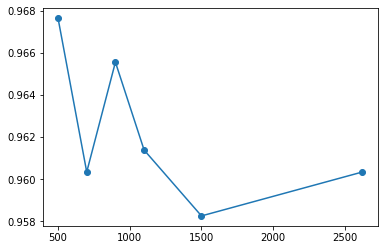

In [0]:
plt.plot(trial,score,'-o')

The PCA with 500 features seems to have slightly higher results. lets take that feature and train on full data without validaiton split

In [0]:
clf1 = SVC(gamma=0.025, C=3,kernel='linear')  
clf1.fit(XP5,Y)

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.025, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
clf1.score(XtP5,Yt)

0.9590643274853801

### Test results (2 mark)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

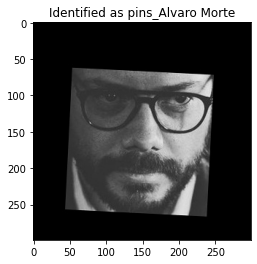

In [0]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
img = (example_image / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
xx=ss.transform(embedding_vector.reshape(1,2622))
xx1=pc5.transform(xx)
example_prediction = clf1.predict(xx1.reshape(1,500))
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

In [0]:
y_test[10]

'pins_Alvaro Morte'

In [0]:
metadata[test_idx][example_idx].name

'pins_Alvaro Morte'

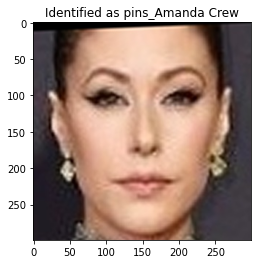

In [0]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 20

example_image = load_image(metadata[test_idx][example_idx].image_path())
img = (example_image / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
xx=ss.transform(embedding_vector.reshape(1,2622))
xx1=pc5.transform(xx)
example_prediction = clf1.predict(xx1.reshape(1,500))
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

In [0]:
y_test[20]

'pins_Amanda Crew'

Thus the model is able recognize the preson in the image

# lets try the same with different method

In [0]:
pc=1100
sampl=50000

In [0]:
pc151=PCA(n_components=pc)
pc151.fit(X_train)
XP151=pc151.transform(X_train)
XtP151=pc151.transform(X_test)

In [0]:
t=[]
t1=[]
for i in range(sampl):
  r=np.random.randint(0,9572)
  j=np.random.randint(0,9572)
  while(1):
    if Y[r]==Y[j]:
      j=np.random.randint(0,9572)
    else:
      break
  t.append(XP151[r])
  t1.append(XP151[j])

In [0]:
kk=np.concatenate((np.array(t),np.array(t1)),axis=1)

In [0]:
t=[]
t1=[]
for i in range(sampl):
  r=np.random.randint(0,9572)
  j=np.random.randint(0,9572)
  while(1):
    if Y[r]==Y[j]:
      break
    else:
      j=np.random.randint(0,9572)
  t.append(XP151[r])
  t1.append(XP151[j])

In [0]:
XP151.shape

(9573, 1100)

In [0]:
kk1=np.concatenate((np.array(t),np.array(t1)),axis=1)

In [0]:
train=np.concatenate((kk,kk1))

In [0]:
train.shape

(100000, 2200)

In [0]:
trainy1=np.ones((sampl,1))


In [0]:
trainy2=np.zeros((sampl,1))

In [0]:
trainy=np.concatenate((trainy1,trainy2))


In [0]:
base_network = Dense(800,activation='relu',input_shape=(pc,))

In [0]:
left_input = Input((pc,))
right_input = Input((pc,))
processed_a = base_network(left_input)
processed_b = base_network(right_input)

In [0]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
    
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model1 = Model(inputs=[left_input, right_input], outputs=distance)

In [0]:
optimizer = Adam(0.001, decay=2.5e-4)

model1.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

In [0]:
model1.fit([train[:,:pc],train[:,pc:]], trainy,
          batch_size=100,
          epochs=25,
          verbose=1,
          validation_split=0.1)

Epoch 1/25
900/900 [==============================] - 3s 4ms/step - loss: 0.1216 - accuracy: 0.9938 - val_loss: 0.2449 - val_accuracy: 0.9883
Epoch 2/25
900/900 [==============================] - 3s 4ms/step - loss: 0.1164 - accuracy: 0.9945 - val_loss: 0.2387 - val_accuracy: 0.9881
Epoch 3/25
900/900 [==============================] - 3s 4ms/step - loss: 0.1121 - accuracy: 0.9950 - val_loss: 0.2345 - val_accuracy: 0.9888
Epoch 4/25
900/900 [==============================] - 3s 3ms/step - loss: 0.1087 - accuracy: 0.9952 - val_loss: 0.2282 - val_accuracy: 0.9893
Epoch 5/25
900/900 [==============================] - 3s 3ms/step - loss: 0.1059 - accuracy: 0.9955 - val_loss: 0.2218 - val_accuracy: 0.9910
Epoch 6/25
900/900 [==============================] - 3s 3ms/step - loss: 0.1034 - accuracy: 0.9957 - val_loss: 0.2200 - val_accuracy: 0.9905
Epoch 7/25
900/900 [==============================] - 3s 4ms/step - loss: 0.1013 - accuracy: 0.9960 - val_loss: 0.2170 - val_accuracy: 0.9910
Epoch 

In [0]:
model1.save_weights('model1.h5')

In [0]:
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1100)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1100)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 800)          880800      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           dense[0][0]                

In [0]:
yy=0
a=[]
database=[]
for i in range(len(XP151)):
  if yy not in a:
    if yy==Y[i]:
      database.append(XP151[i])
      a.append(Y[i])
      yy=yy+1
    

In [0]:
Ytt=np.arange(0,100)

In [0]:
def test(sample):
  yy=[]
  for i in database:
    yy.append(model1.predict([np.array(sample).reshape(1,pc),np.array(i).reshape(1,pc)]))
  return np.argmin(np.array(yy))
  

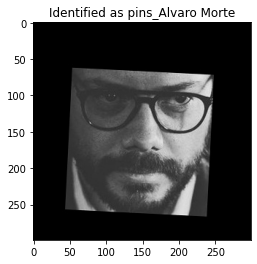

In [0]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
img = (example_image / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
xx1=pc151.transform(embedding_vector.reshape(1,2622))
example_prediction,jj = test(database,xx1)
example_identity = le.inverse_transform([example_prediction])[0]
plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

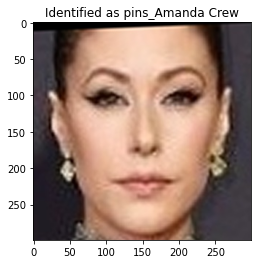

In [0]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 20

example_image = load_image(metadata[test_idx][example_idx].image_path())
img = (example_image / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
xx1=pc151.transform(embedding_vector.reshape(1,2622))
example_prediction = test(database,xx1)
example_identity = le.inverse_transform([example_prediction])[0]
plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

In [0]:
count=0
for i in range(len(XtP151)):
  example_prediction= test(XtP151[i])
  if example_prediction==Yt[i]:
    count=count+1

In [0]:
count


1143

In [0]:
count/len(XtP151)

0.9548872180451128

The accuracy is almost equal to svm model

## Lets try linear SVC

In [21]:
from sklearn.svm import LinearSVC
scoredd=[]
countdd=[]
for i in XX:
  clfk = LinearSVC()   
  x,xv,y,yv=train_test_split(i,Y,test_size=0.1)
  clfk.fit(x, y)
  scoredd.append(clfk.score(xv, yv))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [22]:
scoredd

[0.9519832985386222,
 0.9603340292275574,
 0.9592901878914405,
 0.9572025052192067,
 0.965553235908142,
 0.9676409185803758]

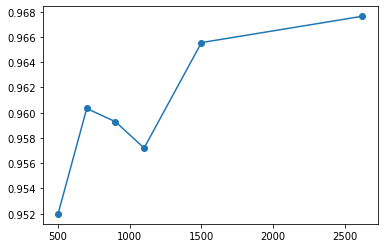

In [29]:
plt.plot(trial,scoredd,'-o')

In [30]:
clfk.fit(X,Y)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [31]:
clfk.score(Xt,Yt)

0.9674185463659147

It seems the LinearSVC gives slightly better result than SCV. but the trend with PCA data seems different between them